<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BNatal%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/nataldiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,24088.0,24088.000000,12018.000000,11978.000000,11964.000000,11846.000000,11968.000000,11682.000000,11512.000000,11512.000000,0.0
mean,82598.0,600.000000,4.622350,29.686717,23.121632,8.183024,5.754353,26.468079,80.200812,4.205078,NaN
std,0.0,600.012455,13.343826,1.151161,2.106824,2.919511,2.253415,1.251795,5.519674,1.214290,NaN
min,82598.0,0.000000,0.000000,23.400000,12.400000,0.000000,0.000000,21.760000,61.500000,0.000000,NaN
25%,82598.0,0.000000,0.000000,29.000000,21.700000,7.000000,4.200000,25.560000,76.500000,3.466667,NaN
50%,82598.0,600.000000,0.000000,29.800000,23.300000,9.300000,5.700000,26.680000,79.500000,4.300000,NaN
75%,82598.0,1200.000000,2.800000,30.400000,24.800000,10.300000,7.300000,27.420000,83.250000,5.033333,NaN
max,82598.0,1200.000000,253.200000,34.000000,28.300000,11.700000,21.700000,29.780000,100.000000,9.233333,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82598,1983-08-01,0,NaN,28.2,NaN,4.1,8.0,NaN,87.75,2.533333,NaN
1,82598,1983-08-01,1200,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82598,1983-08-02,0,NaN,28.2,NaN,8.7,4.3,NaN,92.50,4.833333,NaN
3,82598,1983-08-02,1200,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,82598,1983-08-03,0,NaN,28.5,NaN,9.9,6.9,NaN,89.00,4.000000,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,11978.000000,0.0,11846.000000,11968.000000,11682.000000,11512.000000,11512.000000
mean,NaN,29.686717,NaN,8.183024,5.754353,26.468079,80.200812,4.205078
std,NaN,1.151161,NaN,2.919511,2.253415,1.251795,5.519674,1.214290
min,NaN,23.400000,NaN,0.000000,0.000000,21.760000,61.500000,0.000000
25%,NaN,29.000000,NaN,7.000000,4.200000,25.560000,76.500000,3.466667
50%,NaN,29.800000,NaN,9.300000,5.700000,26.680000,79.500000,4.300000
75%,NaN,30.400000,NaN,10.300000,7.300000,27.420000,83.250000,5.033333
max,NaN,34.000000,NaN,11.700000,21.700000,29.780000,100.000000,9.233333


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,12018.000000,0.0,11964.000000,0.0,0.0,0.0,0.0,0.0
mean,4.622350,NaN,23.121632,NaN,NaN,NaN,NaN,NaN
std,13.343826,NaN,2.106824,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,12.400000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,21.700000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,23.300000,NaN,NaN,NaN,NaN,NaN
75%,2.800000,NaN,24.800000,NaN,NaN,NaN,NaN,NaN
max,253.200000,NaN,28.300000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1983-08-01,28.2,4.1,8.0,NaN,87.75,2.533333
1983-08-02,28.2,8.7,4.3,NaN,92.50,4.833333
1983-08-03,28.5,9.9,6.9,NaN,89.00,4.000000
1983-08-04,28.4,9.4,4.8,NaN,NaN,NaN
1983-08-05,28.0,10.0,2.4,NaN,NaN,NaN


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1983-08-01,0.0,NaN
1983-08-02,2.2,NaN
1983-08-03,0.0,NaN
1983-08-04,0.0,21.2
1983-08-05,0.0,19.8


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,11978.000000,11846.000000,11968.000000,11682.000000,11512.000000,11512.000000,12018.000000,11964.000000
mean,29.686717,8.183024,5.754353,26.468079,80.200812,4.205078,4.622350,23.121632
std,1.151161,2.919511,2.253415,1.251795,5.519674,1.214290,13.343826,2.106824
min,23.400000,0.000000,0.000000,21.760000,61.500000,0.000000,0.000000,12.400000
25%,29.000000,7.000000,4.200000,25.560000,76.500000,3.466667,0.000000,21.700000
50%,29.800000,9.300000,5.700000,26.680000,79.500000,4.300000,0.000000,23.300000
75%,30.400000,10.300000,7.300000,27.420000,83.250000,5.033333,2.800000,24.800000
max,34.000000,11.700000,21.700000,29.780000,100.000000,9.233333,253.200000,28.300000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1983-08-01,4.1,8.0,NaN,87.75,2.533333,0.0,NaN
1983-08-02,8.7,4.3,NaN,92.50,4.833333,2.2,NaN
1983-08-03,9.9,6.9,NaN,89.00,4.000000,0.0,NaN
1983-08-04,9.4,4.8,NaN,NaN,NaN,0.0,21.2
1983-08-05,10.0,2.4,NaN,NaN,NaN,0.0,19.8


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1983-08-01    28.2
1983-08-02    28.2
1983-08-03    28.5
1983-08-04    28.4
1983-08-05    28.0
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,11812.000000,11906.000000,11676.000000,11478.000000,11447.000000,11950.000000,11942.000000
mean,0.399159,-0.470159,0.174127,-0.028407,-0.088667,-0.963455,0.348783
std,0.498703,0.207483,0.312152,0.286407,0.263221,0.105504,0.265079
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.196581,-0.612903,-0.052369,-0.220779,-0.249097,-1.000000,0.169811
50%,0.589744,-0.474654,0.226933,-0.064935,-0.068592,-1.000000,0.371069
75%,0.760684,-0.336406,0.411471,0.129870,0.090253,-0.977883,0.559748
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(11978, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 655.4427 - mean_absolute_error: 25.4726
Epoch 2/200
 - 1s - loss: 366.5932 - mean_absolute_error: 19.0411
Epoch 3/200
 - 1s - loss: 193.7623 - mean_absolute_error: 13.8012
Epoch 4/200
 - 1s - loss: 89.2580 - mean_absolute_error: 9.2998
Epoch 5/200
 - 1s - loss: 33.4546 - mean_absolute_error: 5.5870
Epoch 6/200
 - 1s - loss: 9.5889 - mean_absolute_error: 2.8415
Epoch 7/200
 - 1s - loss: 2.5559 - mean_absolute_error: 1.3416
Epoch 8/200
 - 1s - loss: 1.4102 - mean_absolute_error: 0.9472
Epoch 9/200
 - 1s - loss: 1.3333 - mean_absolute_error: 0.9044
Epoch 10/200
 - 1s - loss: 1.3319 - mean_absolute_error: 0.9017
Epoch 11/200
 - 1s - loss: 

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.248706, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.248706 (0.008508) {'batch_size': 10, 'camadas': 2, 'units': 7}


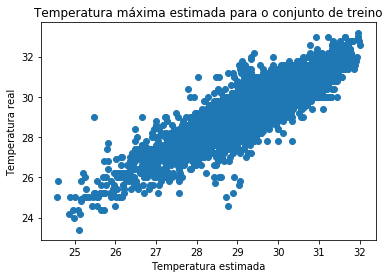

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.90340089]
 [0.90340089 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

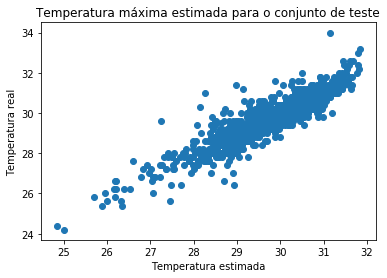

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.91017545]
 [0.91017545 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.3480393035582987


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.2345329217534647


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1983-08-04,28.4,9.4,4.8,NaN,NaN,NaN,0.0
1983-08-05,28.0,10.0,2.4,NaN,NaN,NaN,0.0
1983-08-06,29.0,8.9,6.6,NaN,NaN,NaN,0.0
1983-08-07,28.8,9.9,10.0,NaN,NaN,NaN,0.4
1983-08-08,28.2,6.1,18.5,NaN,NaN,NaN,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1983-08-04    21.2
1983-08-05    19.8
1983-08-06    23.4
1983-08-07    24.4
1983-08-08    25.0
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,11942.000000,11801.000000,11895.000000,11675.000000,11469.000000,11432.000000,11938.000000
mean,0.186518,0.399095,-0.470081,0.174229,-0.028636,-0.088956,-0.963423
std,0.217069,0.498640,0.207472,0.311977,0.286355,0.263207,0.105555
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.056604,0.196581,-0.612903,-0.052369,-0.220779,-0.249097,-1.000000
50%,0.207547,0.589744,-0.474654,0.226933,-0.064935,-0.068592,-1.000000
75%,0.320755,0.760684,-0.336406,0.411471,0.129870,0.090253,-0.977883
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(11964, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 366.8186 - mean_absolute_error: 18.9017
Epoch 2/200
 - 1s - loss: 168.3293 - mean_absolute_error: 12.7081
Epoch 3/200
 - 1s - loss: 69.8886 - mean_absolute_error: 7.9975
Epoch 4/200
 - 1s - loss: 24.3323 - mean_absolute_error: 4.4401
Epoch 5/200
 - 1s - loss: 8.3281 - mean_absolute_error: 2.4199
Epoch 6/200
 - 1s - loss: 4.8146 - mean_absolute_error: 1.8240
Epoch 7/200
 - 1s - loss: 4.4531 - mean_absolute_error: 1.7377
Epoch 8/200
 - 1s - loss: 4.4412 - mean_absolute_error: 1.7309
Epoch 9/200
 - 1s - loss: 4.5014 - mean_absolute_error: 1.7315
Epoch 10/200
 - 1s - loss: 4.4277 - mean_absolute_error: 1.7278
Epoch 11/200
 - 1s - loss: 4.4014 - mean_absolute_error: 1.7232
Epoch 12/200
 - 1s - loss: 4.1390 - mean_absolute_error: 1.6700
Epoch 13/200
 - 1s - l

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.263004, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.263004 (0.034827) {'batch_size': 10, 'camadas': 2, 'units': 7}


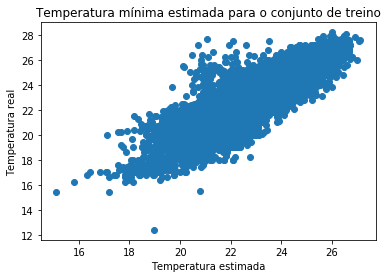

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.85942054]
 [0.85942054 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

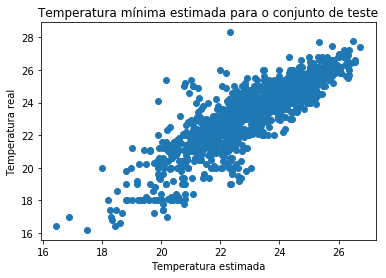

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.86277287]
 [0.86277287 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.8420803720192204


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

1.2376071934478432


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaNatal.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaNatal.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))